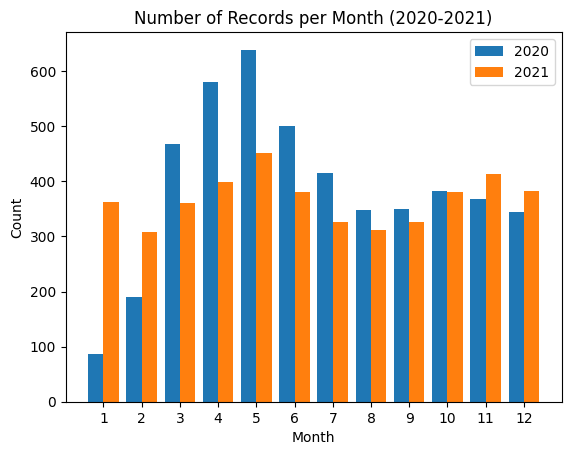

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -127.800
Date:                Fri, 19 May 2023   AIC                            267.601
Time:                        19:07:49   BIC                            274.669
Sample:                             0   HQIC                           269.476
                                 - 24                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    152.5148    112.481      1.356      0.175     -67.944     372.974
ar.L1          1.1551      0.237      4.883      0.000       0.691       1.619
ar.L2         -0.2509      0.266     -0.943      0.346      -0.772       0.270
ar.L3         -0.7516      0.360     -2.086      0.037      -1.458      -0.046
ar.L4          0.4383      0.340      1.288      0.198      -0.229       1.105
sigma2      2075.7287    983.295      2.111      0.035     148.505    4002.952
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.78   Prob(JB):                         0.73
Heteroskedasticity (H):               0.25   Skew:                            -0.21
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima

df_data = pd.read_csv("gymdata-10000.csv")
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Extract the year and month from the 'Date' column
df_data['Year'] = df_data['Date'].dt.year
df_data['Month'] = df_data['Date'].dt.month

# Group and count the records for each year and month
monthly_counts = df_data.groupby(['Year', 'Month']).size()

# Create the x-axis values
months = np.arange(1, 13)

# Reindex the monthly counts to ensure all months are present
monthly_counts = monthly_counts.reindex(pd.MultiIndex.from_product([df_data['Year'].unique(), months]), fill_value=0)

# Filter the data for each year
df_2020 = monthly_counts.loc[2020]
df_2021 = monthly_counts.loc[2021]

# Calculate the number of years
num_years = len([df_2020, df_2021])

# Combine the monthly counts from all years
monthly_counts_all = pd.concat([df_2020, df_2021])

# Use auto_arima to determine the best ARIMA model
model = auto_arima(monthly_counts_all, seasonal=True, m=12)

# Plot the counts for each year side by side
bar_width = 0.8 / num_years

plt.bar(months - bar_width/2, df_2020, width=bar_width, label='2020')
plt.bar(months + bar_width/2, df_2021, width=bar_width, label='2021')

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Number of Records per Month (2020-2021)')
plt.legend()

# Set the x-axis ticks
plt.xticks(months)

# Show the plot
plt.show()

# Display the model summary
model.summary()

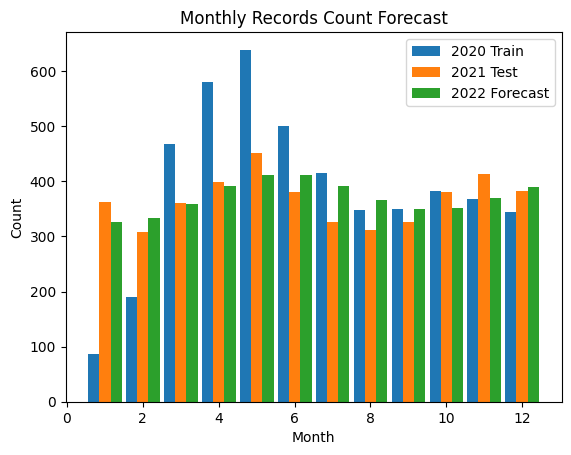

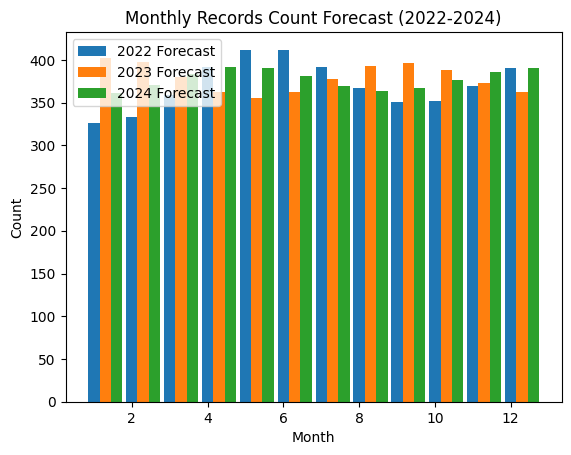

In [64]:
from statsmodels.tsa.arima.model import ARIMA

# Reindex the monthly counts to ensure all months are present
monthly_counts = monthly_counts.reindex(pd.MultiIndex.from_product([df_data['Year'].unique(), months]), fill_value=0)

# Split the data into training and test sets
train_data = monthly_counts[:-12].values  # Use data until the last 12 months as training
test_data = monthly_counts[-12:].values  # Use the last 12 months as test

# Fit the ARIMA model with order (4,0,0) using the training data
order = (4, 0, 0)
model = ARIMA(train_data, order=order)
model_fit = model.fit()

# Get the forecasted values for the test period
forecast = model_fit.forecast(steps=len(test_data))

# Create the x-axis values
months = np.arange(1, 13)

# Set the width of the bars
bar_width = 0.30
gap = 0.01

# Set the positions of the bars
bar_positions_train = months - bar_width + gap
bar_positions_test = months
bar_positions_forecast = months + bar_width

# Plot the actual values and the forecasted values for the test period as bar charts
plt.bar(bar_positions_train, train_data, width=bar_width, label='2020 Train')
plt.bar(bar_positions_test, test_data, width=bar_width, label='2021 Test')
plt.bar(bar_positions_forecast, forecast, width=bar_width, label='2022 Forecast')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Records Count Forecast')
plt.legend()
plt.show()

# Use the fitted model to predict the values for 2022
forecast_2022 = model_fit.forecast(steps=12)

# Use the fitted model to predict the values for 2023
model_fit_2023 = ARIMA(np.concatenate([monthly_counts, forecast_2022]), order=order).fit()
forecast_2023 = model_fit_2023.forecast(steps=12)

# Use the fitted model to predict the values for 2024
model_fit_2024 = ARIMA(np.concatenate([monthly_counts, forecast_2022, forecast_2023]), order=order).fit()
forecast_2024 = model_fit_2024.forecast(steps=12)

# Plot the forecasted values for 2022, 2023, and 2024 as a bar chart
plt.bar(months, forecast_2022, width=bar_width, label='2022 Forecast')
plt.bar(months + bar_width, forecast_2023, width=bar_width, label='2023 Forecast')
plt.bar(months + 2 * bar_width, forecast_2024, width=bar_width, label='2024 Forecast')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Records Count Forecast (2022-2024)')
plt.legend()
plt.show()

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(test_data, forecast)
mae

30.200431211766723

In [61]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
rmse

35.491335384377805

In [62]:
# Calculate MAPE
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
mape

8.46790032431789